In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from tabulate import tabulate
from sklearn.metrics.pairwise import cosine_similarity
plt.style.use('seaborn-v0_8-whitegrid')

companies = ["Acerinox", "ACS", "Bancosantander", "Bankinter", "BBVA", "Caixa", "Colonial", "Enagas", "Endesa", "Ferrovial", "Grifols", "IAG", "Iberdrola", "Inditex", 'Acciona', 
             'Arcelormittal', 'Bancosabadell', 'Cellnex', 'Fluidra', 'Indra', 'Logista', 'Melia', 'Merlin', 'Naturgy', 'Red', 'Repsol', 'Rovi', 'Sacyr', 'Solaria', 'Telefonica']
print(f"Analyzing {len(companies)} companies.")

Analyzing 30 companies.


# Analysis

We carry out three types of analysis, all at **company** level, i.e., for each company:
1. Best matching: We generate a set of queries to find the best match in a language set given a PR in the other language. More precisely, each PR in English is treated as a query and the search for the closest PR in the Spanish set. Then, the opposite is done, taking each PR in Spanish as a query, and searching for the closest match in English. The raw associations are found in the files called `comparison_{company}_{direction}.xlsx`, where the direction indicates which of the two languages is used as query. The first table below reports the average across all the PR of a given company.
2. Topic modeling and comparison: We extract the top $n$ topics in the English and Spanish sets (in my exercise below, $n=10$). We then compute the distance between the topics in the two languages. More precisely, we first find the best match between each pair of topics and then we compute the average distance across the pairs of best matches.
3. Topics for the PR with low similarity score. We select the Spanish PR whose similarity score with the closest English PR is in the bottom 20th percentile. For these **low similarity** PRs, we extract the main topics. That is, we want to identify which topics are discussed in Spanish but not in English. 

## Best Matching 

The file below provides the average similarity across all the pairs, obtained as described above. In the folder `results/best_matching`, you find the details of each comparison. For the sake of clarity, I show below an example for Inditex. 

In [2]:
df = pd.read_excel("results/avg_similarity_company_both.xlsx")
df

company  nr_en  nr_es  similarity_en_to_es  similarity_es_to_en
0              ACS    318    323             0.969719             0.966951
1          Acciona    887   1074             0.930277             0.895565
2         Acerinox    229    236             0.933870             0.934255
3    Arcelormittal    447    192             0.775290             0.828281
4             BBVA    238    522             0.916734             0.787370
5    Bancosabadell    294    770             0.941250             0.803138
6   Bancosantander    698   1102             0.914989             0.863949
7        Bankinter    612    613             0.951773             0.951053
8            Caixa    645   2935             0.939889             0.795946
9          Cellnex    253    239             0.928249             0.935922
10        Colonial     33     34             0.929559             0.931215
11          Enagas    352    391             0.928380             0.924157
12          Endesa    149    144             0.837463             0.845673
13       Ferrovial    365    362             0.915678             0.915986
14         Fluidra    154    157             0.934247             0.930480
15         Grifols    257    253             0.918767             0.920675
16             IAG    219    235             0.908883             0.915402
17       Iberdrola    947    903             0.952832             0.953410
18         Inditex    154    154             0.938037             0.938037
19           Indra    921   1570             0.931471             0.864217
20         Logista    248    251             0.939693             0.939008
21           Melia    182    492             0.875372             0.799480
22          Merlin     81     85             0.946587             0.944107
23         Naturgy    279    821             0.934456             0.813228
24             Red    542    580             0.938290             0.925317
25          Repsol    330    410             0.935823             0.897344
26            Rovi    207    211             0.933189             0.912962
27           Sacyr    243    244             0.940351             0.939357
28         Solaria    171    172             0.916651             0.913492
29      Telefonica    771   1837             0.927124             0.814919

Let us consider the case of Inditex. The average similarity value is obtained from the file below, where each row shows the best match between PR in the two languages. We also have the similarity score and the filenames of the two PRs. **NOTE**: Watch out for similarity scores of 1.0, since they are probably associated to errors. Two PRs in different languages should not give a score of 1.0, since a *perfect* translation does not exist. If we get a score of 1.0, we probably have an error (e.g., a duplicated PR.)

In [3]:
dfI = pd.read_excel("results/best_matching/comparison_Inditex_en2es.xlsx")
dfI.head(3)

idx_query  similarity                                              query  \
0          0    0.931580  1 dic 2014Zara opens a flagship on Shanghai's ...   
1          1    0.906590  1 jul 2015Inditex provides grant to Every Moth...   
2          2    0.895191  1 sept 2014Stradivarius opens its first UK sto...   

                                               match  idx_match  \
0  1 dic 2014Zara abre una tienda emblemática en ...          0   
1  1 jul 2015Inditex y ‘Every Mother Counts' firm...          1   
2  1 sept 2014Stradivarius abre en Londres su pri...          2   

                                      query_filename  \
0  data/raw/Inditex/eng/57f7be58-1389-4f00-b4c0-9...   
1  data/raw/Inditex/eng/a307c7fe-87e8-462f-a8f3-8...   
2  data/raw/Inditex/eng/a2c6c52a-3fe9-486b-9a06-1...   

                                      match_filename  
0  data/raw/Inditex/esp/57f7be58-1389-4f00-b4c0-9...  
1  data/raw/Inditex/esp/a307c7fe-87e8-462f-a8f3-8...  
2  data/raw/Inditex/esp/a2c6c52a-3fe9-486b-9a06-1...

The plot below shows the *variability* of the similarity scores. This could be useful to identify companies with larger variability, as well as cases with low matching. For example, observe below:
1. The case of Colonial, which is obviously wrong, since we have a perfect match of 100%. If you have a look at the original PRs, you will see what the problem is.
2. The case of, e.g., Endesa vs. Inditex. While the former has large variability, indicating that quite often we don't find strong matches, the latter seems to correspond to good translations between english and spanish.
I suggest to use this plot to identify what and where to explore.

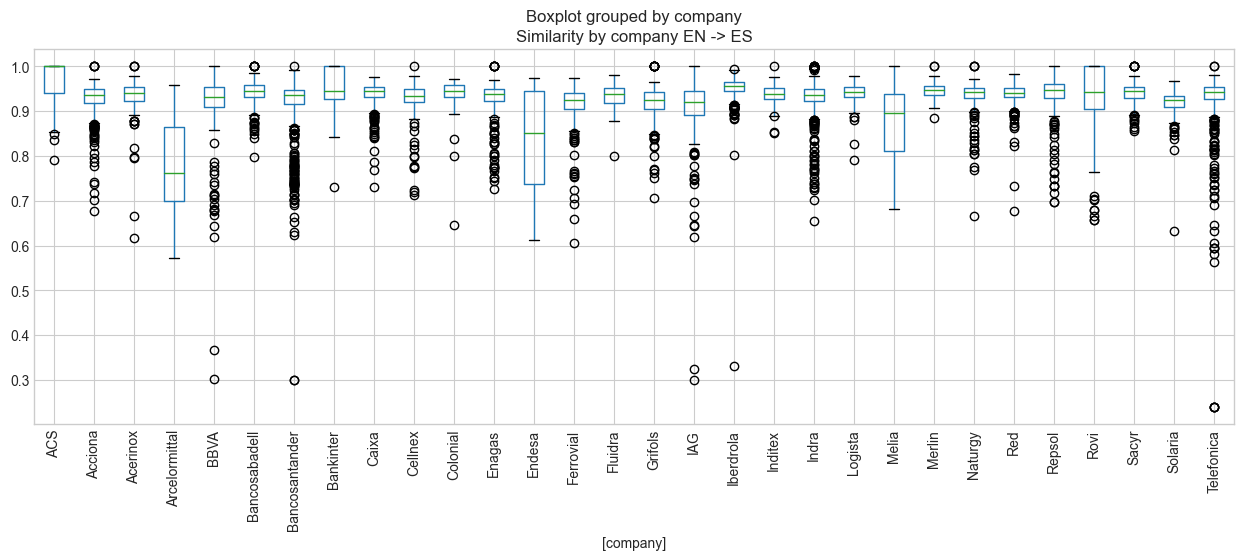

In [4]:
for i, company in enumerate(companies):
    dfI = pd.read_excel(f"results/best_matching/comparison_{company}_en2es.xlsx")
    dfI["company"] = company
    if i == 0:
        df = dfI[["company", "similarity"]]
    else:
        df = pd.concat([df, dfI[["company", "similarity"]]])

df.boxplot(by="company", figsize=(15,5))
plt.title("Similarity by company EN -> ES")
plt.xticks(rotation=90);

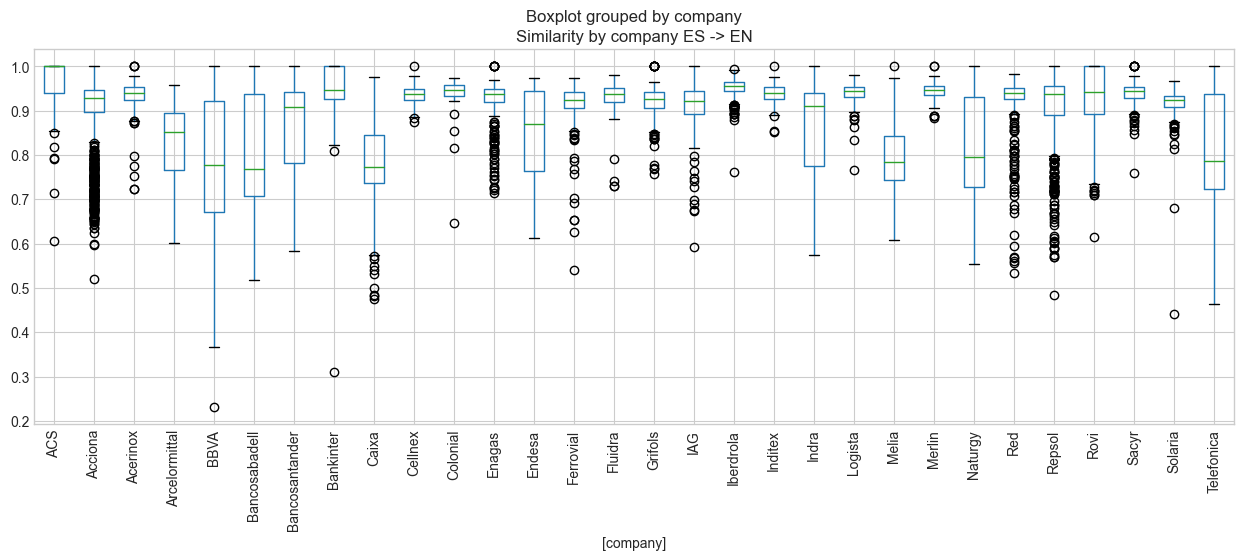

In [5]:
for i, company in enumerate(companies):
    dfI = pd.read_excel(f"results/best_matching/comparison_{company}_es2en.xlsx")
    dfI["company"] = company
    if i == 0:
        df = dfI[["company", "similarity"]]
    else:
        df = pd.concat([df, dfI[["company", "similarity"]]])

df.boxplot(by="company", figsize=(15,5))
plt.title("Similarity by company ES -> EN")
plt.xticks(rotation=90);

## Topics Modeling

Here we analyze the distribution of similarity scores for all the **topics**, and not just the PR (as above).

company  similarity
0              ACS    0.723991
1          Acciona    0.649052
2         Acerinox    0.871268
3    Arcelormittal    0.721237
4             BBVA    0.708271
5    Bancosabadell    0.749090
6   Bancosantander    0.748163
7        Bankinter    0.855400
8            Caixa    0.797540
9          Cellnex    0.817498
10        Colonial    0.853307
11          Enagas    0.795909
12          Endesa    0.760369
13       Ferrovial    0.778183
14         Fluidra    0.810223
15         Grifols    0.753697
16             IAG    0.775684
17       Iberdrola    0.785209
18         Inditex    0.769948
19           Indra    0.702316
20         Logista    0.785620
21           Melia    0.716072
22          Merlin    0.828489
23         Naturgy    0.822847
24             Red    0.803568
25          Repsol    0.839572
26            Rovi    0.695451
27           Sacyr    0.826867
28         Solaria    0.876840
29      Telefonica    0.641181

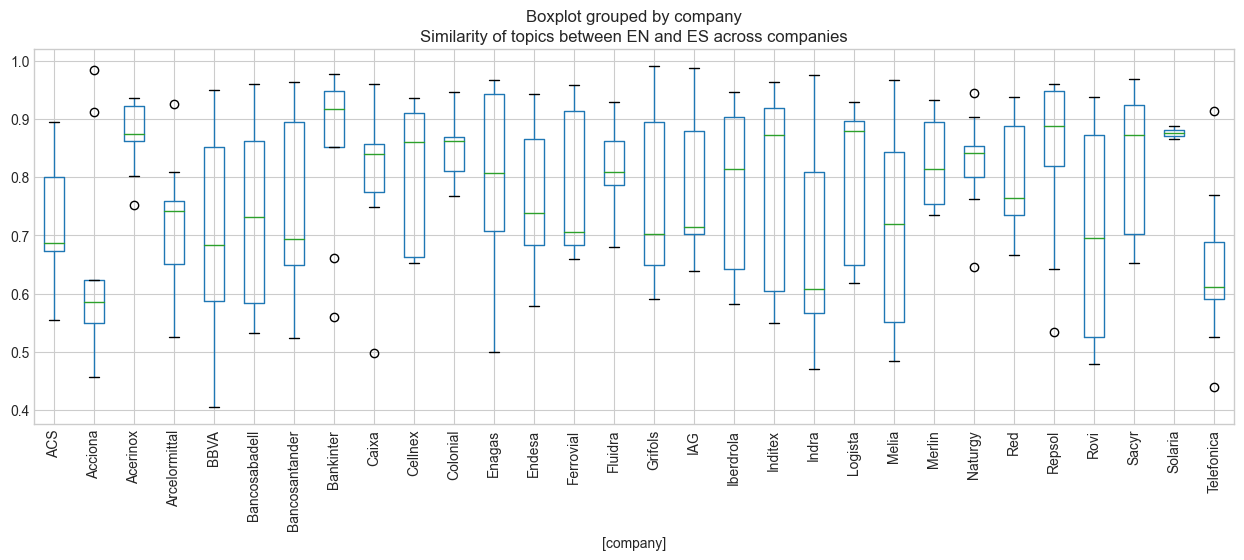

In [6]:
for i, company in enumerate(companies):
    dfI = pd.read_excel(f"results/topics/topics_match_{company}.xlsx")
    dfI["company"] = company
    if i == 0:
        df = dfI[["company", "similarity"]]
    else:
        df = pd.concat([df, dfI[["company", "similarity"]]])

df.boxplot(by="company", figsize=(15,5))
plt.title("Similarity of topics between EN and ES across companies")
plt.xticks(rotation=90);
df.groupby("company").similarity.mean().reset_index()

### Full List of Matches Across Topics

Below, I print out the content of each file of the type `topics_match_company.xlsx`, to save you the time to open each excel file. To reduce the output, here I print only the topics of `Acerinox`. However, if you open the excel files, you can find the topics of each company in the list.

In [7]:
#for i, company in enumerate(companies):
for i, company in enumerate(['Rovi']):
    dfI = pd.read_excel(f"results/topics/topics_match_{company}.xlsx")
    print(f"\n\nCompany '{company}'")
    print("-"*len(f"Company '{company}'"))
    #print(dfI.to_markdown(index=False))
    print(tabulate(dfI, headers='keys', tablefmt='fancy_grid'))



Company 'Rovi'
--------------
╒════╤═════════╤═════════╤══════════════════════════════════════════════════╤═══════════╤═══════════╤════════════════════════════════════════════════════╤══════════════╕
│    │   Topic │   Count │ Name EN                                          │   Topic.1 │   Count.1 │ Best Match ES                                      │   similarity │
╞════╪═════════╪═════════╪══════════════════════════════════════════════════╪═══════════╪═══════════╪════════════════════════════════════════════════════╪══════════════╡
│  0 │       0 │   14648 │ 0_euros_sales_million_purchase                   │         0 │     13024 │ 0_ventas_euros_ingresos_2022                       │     0.890649 │
├────┼─────────┼─────────┼──────────────────────────────────────────────────┼───────────┼───────────┼────────────────────────────────────────────────────┼──────────────┤
│  1 │       1 │     189 │ 1_breezhaler_pulmonary_copd_hypercholesterolemia │         3 │        68 │ 3_breezhaler_pul

### Topics Details

The files `topics/topics_details_company.xlsx` provides a detailed view of what is contained in each topic. Let me show you the example of Inditex. The column `index` allows to identify the two blocks (english topics have index $0$ to $9$, and spanish topics start over from $0$ to $9$ again, since we extract the $10$ top terms for each topic, first in english and then in spanish.) Columnwise you get the different topics, thus we have as many columns as topics generated. I am asking the model to give me 10 topics but this is not always possible. Therefore, it could happen that we have less than 10 columns. 

Each column provided the english topic and the best matching spanish topic. That is, consider the table with the best topic matches below:

In [8]:
pd.read_excel(f"results/topics/topics_match_Rovi.xlsx")

Topic  Count                                           Name EN  Topic.1  \
0      0  14648                    0_euros_sales_million_purchase        0   
1      1    189  1_breezhaler_pulmonary_copd_hypercholesterolemia        3   
2      2     70                    2_lines_total_packaging_líneas        0   
3      3     39            3_subsidies_excluding_taxes_calculated        2   
4      4     33                      4_chairman2_letter_chairman_        0   
5      5     18             5_cancer_chemotherapy_tumour_platinum        3   
6      6     18                                  6_menu5_18_14_12        6   
7      7     16                        7_refers_profit_net_period        0   
8      8     16                 8_bladder_urine_urination_urinary        7   

   Count.1                                      Best Match ES  similarity  
0    13024                       0_ventas_euros_ingresos_2022    0.890649  
1       68  3_breezhaler_pulmonar_enfermedad_broncodilatad...    0.937573  
2    13024                       0_ventas_euros_ingresos_2022    0.694916  
3      110    2_impuestos_depreciaciones_amortizaciones_taxes    0.873028  
4    13024                       0_ventas_euros_ingresos_2022    0.478455  
5       68  3_breezhaler_pulmonar_enfermedad_broncodilatad...    0.517795  
6       19                             6_anexosmenú7_anexos__    0.525701  
7    13024                       0_ventas_euros_ingresos_2022    0.772037  
8       18    7_hipercolesterolemia_aumenta_sangre_colesterol    0.568909

Assume you want to dig into each topic, e.g., `topic_0`. From the table above, we see that topic 0 in english contains words such as *store, spain*, etc., while the spanish topic contains *dutti, bear*, etc. Now, if you look at the table below, under column `topic_0`, you get the full list (i.e., the top 10 terms in the topic, first in english and then in spanish.)

In [9]:
pd.read_excel("results/topics/topics_details_Inditex.xlsx")

index                                topic_0  \
0       0         ('store', 0.26394370400208217)   
1       1         ('spain', 0.24268316990144728)   
2       2        ('stores', 0.24201567237487906)   
3       3        ('opened', 0.22778965198711296)   
4       4         ('sales', 0.22636350246669495)   
5       5       ('million', 0.22500919773470632)   
6       6          ('bear', 0.22079948324559304)   
7       7         ('profit', 0.2194084672016085)   
8       8       ('shopping', 0.2144725395333686)   
9       9         ('china', 0.21340553016033806)   
10      0          ('dutti', 0.2599133665559594)   
11      1          ('bear', 0.25698095575939556)   
12      2        ('tienda', 0.24827711081991186)   
13      3          ('euros', 0.2372428620944041)   
14      4        ('ventas', 0.23611172498699862)   
15      5  ('stradivarius', 0.23428763812657605)   
16      6     ('dividendo', 0.21217854490764804)   
17      7       ('tiendas', 0.21097419422600525)   
18      8       ('trabajo', 0.20313064223736466)   
19      9      ('beneficio', 0.1951388652322703)   

                                    topic_1  \
0           ('markets', 0.5324681506427771)   
1            ('online', 0.4621054537851776)   
2            ('stores', 0.4387556009137201)   
3            ('expand', 0.3287739182777003)   
4          ('finland', 0.32104363807349984)   
5         ('platforms', 0.3168712891432323)   
6         ('countries', 0.3138985006419049)   
7           ('europe', 0.30826558094115386)   
8         ('slovenia', 0.30078877927747466)   
9           ('croatia', 0.2924768076799347)   
10          ('mercados', 0.542448203282406)   
11          ('tiendas', 0.4866748834772427)   
12           ('online', 0.4183662201458335)   
13          ('turquía', 0.3967509268737034)   
14        ('comercial', 0.3713379005913231)   
15           ('países', 0.3705326171024336)   
16  ('establecimientos', 0.352026283419327)   
17            ('malta', 0.3225925582860526)   
18          ('europa', 0.31987082343321466)   
19         ('bulgaria', 0.3180058269135388)   

                                 topic_2  \
0        ('textile', 0.4336948236068981)   
1     ('materials', 0.40041827968640764)   
2       ('garments', 0.3878622277024425)   
3          ('fiber', 0.3678144691607375)   
4        ('fabrics', 0.3586345829217239)   
5      ('clothing', 0.34565648021990625)   
6           ('wood', 0.3299143491351075)   
7       ('recycled', 0.3275760466124166)   
8         ('fibres', 0.3055370176744884)   
9        ('garment', 0.3018597754940443)   
10        ('textil', 0.7868052753861249)   
11        ('fibras', 0.6903244101593469)   
12          ('fibra', 0.683311387444974)   
13         ('fiber', 0.6575960259376952)   
14       ('algodón', 0.6058873779177674)   
15      ('reciclaje', 0.544682515436719)   
16       ('lenzing', 0.5268815185633595)   
17      ('textiles', 0.5149841229423846)   
18       ('cotton', 0.41803350554430363)   
19  ('sostenibles', 0.41100755029853725)   

                                   topic_3  \
0         ('lighting', 0.5615787559024172)   
1         ('building', 0.5186676075599268)   
2    ('architectural', 0.4820666499109144)   
3           ('glass', 0.42825161292636377)   
4        ('balconies', 0.4006899162419835)   
5       ('architect', 0.38211510783817376)   
6        ('modernist', 0.3727991848913497)   
7         ('screens', 0.36577817615098335)   
8            ('brick', 0.3539248225315275)   
9   ('refurbishment', 0.34087259713588897)   
10           ('dutti', 0.2599133665559594)   
11           ('bear', 0.25698095575939556)   
12         ('tienda', 0.24827711081991186)   
13           ('euros', 0.2372428620944041)   
14         ('ventas', 0.23611172498699862)   
15   ('stradivarius', 0.23428763812657605)   
16      ('dividendo', 0.21217854490764804)   
17        ('tiendas', 0.21097419422600525)   
18        ('trabajo', 0.20313064223736466)   
19       ('beneficio', 0.1951388652322703)   

                               

# Topics for the PR with low similarity score

We want to identify which topics are discussed in Spanish but not in English. To do this, we identify the PRs with a similarity score in the bottom 20th percentile, i.e., the PRs whose match in English is low. Once we select these PRs with low similarity score, we extrac the topics discussed there.

Below, we present the full list of topics for the PR with low similarity in english first (this  should give an idea of which topics are discussed in the english PR that have no match in the spanish corpus), and in spanish next (scroll below).

## Topics in English PR with low match (no equivalent in Spanish)

In [10]:
for i, company in enumerate(companies):
    dfI = pd.read_excel(f"results/topics/topics_details_lowsim_{company}_en.xlsx")
    print(f"\n\nCompany '{company}'")
    #print("-"*len(f"Company '{company}'"))
    #print(dfI.to_markdown(index=False))
    decimals = 2
    for col in dfI.columns:
        dfI[col] = dfI[col].apply(lambda x: (x.split(",")[0].strip(" ('"), round(float(x.split(",")[1].strip(" )")),2)))
    print(tabulate(dfI,  tablefmt='fancy_grid'))



Company 'Acerinox'
╒═══╤════════════════════════╤═════════════════════════╤══════════════════════════╤═════════════════════╤═════════════════════════╤═════════════════════════╤══════════════════════════╤════════════════════════╤═════════════════════════╕
│ 0 │ ('dividend', 0.85)     │ ('sustainable', 0.9)    │ ('metals', 0.7)          │ ('ebitda', 0.6)     │ ('donations', 0.64)     │ ('director', 0.47)      │ ('steel', 0.3)           │ ('improvement', 0.52)  │ ('digital', 0.79)       │
├───┼────────────────────────┼─────────────────────────┼──────────────────────────┼─────────────────────┼─────────────────────────┼─────────────────────────┼──────────────────────────┼────────────────────────┼─────────────────────────┤
│ 1 │ ('payment', 0.73)      │ ('banks', 0.74)         │ ('vdm', 0.66)            │ ('million', 0.53)   │ ('gibraltar', 0.61)     │ ('chairman', 0.46)      │ ('market', 0.26)         │ ('savings', 0.45)      │ ('360', 0.64)           │
├───┼────────────────────────┼─────

## Topics in Spanish PR with low match (no equivalent in English)

In [11]:
for i, company in enumerate(companies):
    dfI = pd.read_excel(f"results/topics/topics_details_lowsim_{company}_es.xlsx")
    print(f"\n\nCompany '{company}'")
    #print("-"*len(f"Company '{company}'"))
    #print(dfI.to_markdown(index=False))
    decimals = 2
    for col in dfI.columns:
        dfI[col] = dfI[col].apply(lambda x: (x.split(",")[0].strip(" ('"), round(float(x.split(",")[1].strip(" )")),2)))
    print(tabulate(dfI,  tablefmt='fancy_grid'))



Company 'Acerinox'
╒═══╤══════════════════════════╤══════════════════════════╤══════════════════════════╤══════════════════════════╤═══════════════════════╤══════════════════════════╤══════════════════════════╤════════════════════════╤════════════════════════╕
│ 0 │ ('inoxidable', 0.35)     │ ('sostenible', 0.44)     │ ('harvard', 0.53)        │ ('presidente', 0.47)     │ ('gibraltar', 0.42)   │ ('excellence', 0.46)     │ ('accionistas', 0.61)    │ ('estratégicas', 0.44) │ ('impuestos', 0.72)    │
├───┼──────────────────────────┼──────────────────────────┼──────────────────────────┼──────────────────────────┼───────────────────────┼──────────────────────────┼──────────────────────────┼────────────────────────┼────────────────────────┤
│ 1 │ ('mercado', 0.34)        │ ('sostenibilidad', 0.41) │ ('business', 0.47)       │ ('igualdad', 0.47)       │ ('emisiones', 0.39)   │ ('digital', 0.45)        │ ('general', 0.55)        │ ('mejorarán', 0.42)    │ ('921', 0.68)          │
├───┼──────

## Bar Plots of Topics

I do not think this is especially useful, since it is just a graphical representation of the table above. However, we can also produce these types of plots, for the sake of comparison. Below I show the example of Inditex. All the other plots are in the folder `results/topics/figures`.

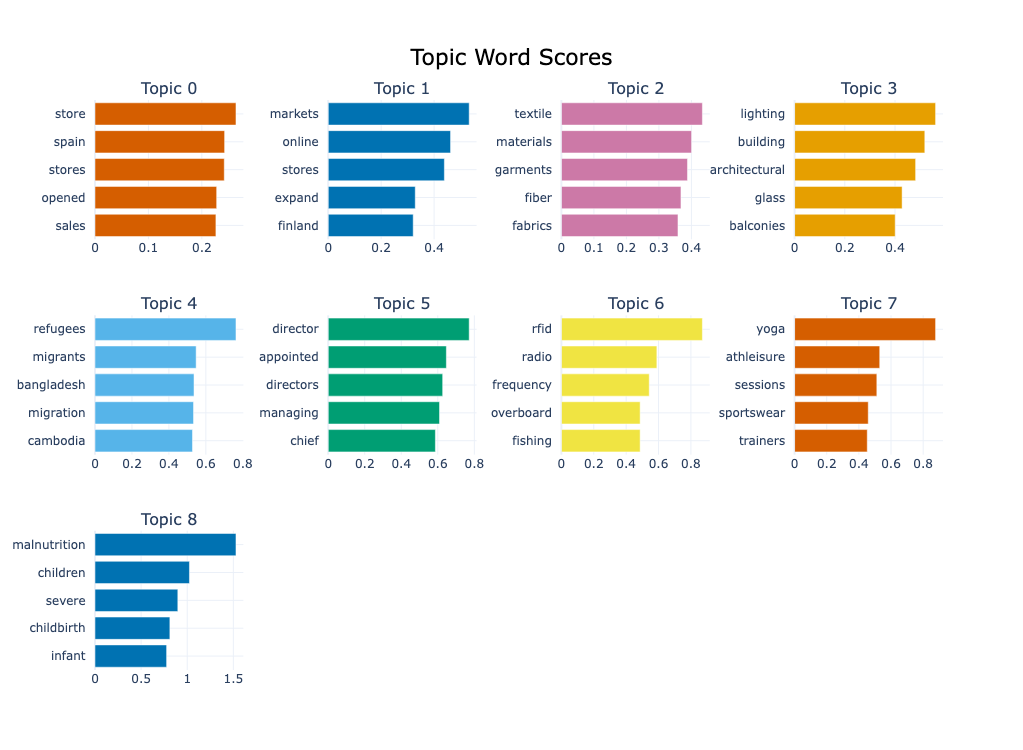

In [10]:
model_en = BERTopic.load("models/Inditex_en.bert")
model_es = BERTopic.load("models/Inditex_es.bert")
fig = model_en.visualize_barchart(n_words=5, top_n_topics=10)
fig

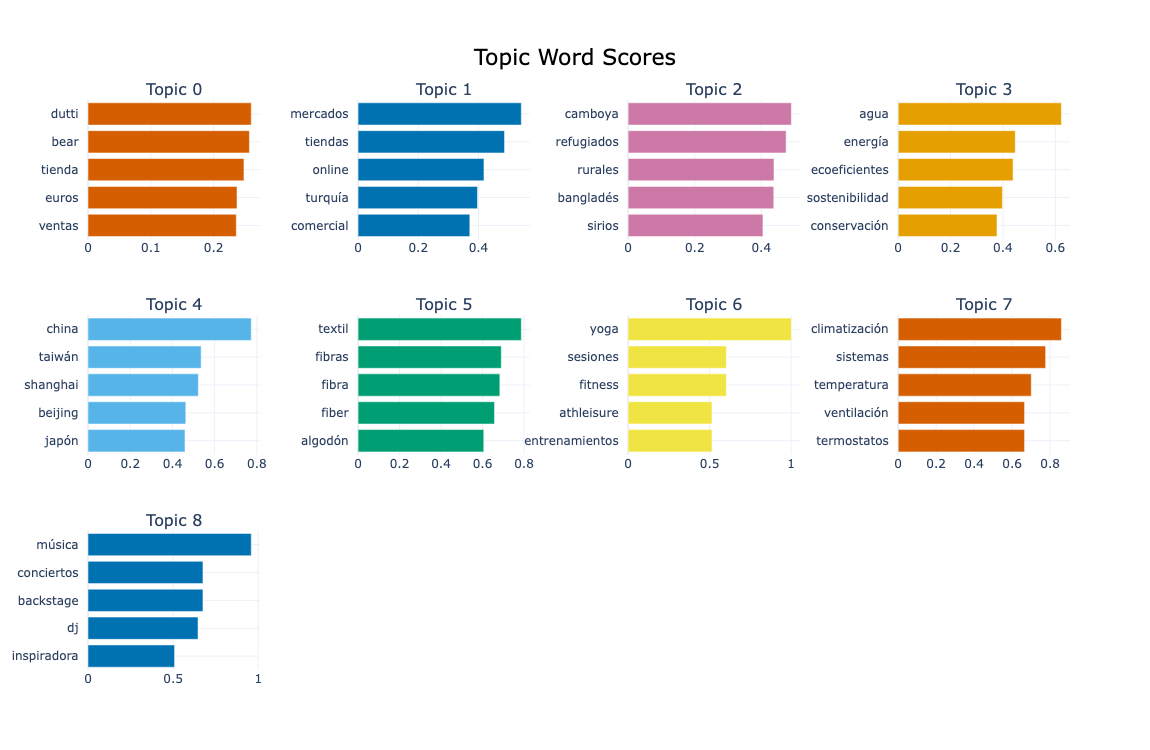

In [11]:
fig = model_es.visualize_barchart(n_words=5, top_n_topics=10)
fig

## Auxiliary Code (ignore this part)

In [ ]:
# generation of different views of topics

for i, company in enumerate(companies):
    model_en = BERTopic.load(f"models/{company}_en.bert")
    model_es = BERTopic.load(f"models/{company}_es.bert")
    
    # compute topics similarity (match best topics and compute distances)
    M = cosine_similarity(model_en.topic_embeddings_[1:], model_es.topic_embeddings_[1:])
    idx = np.argmax(M, axis=1).tolist() # best match for each english topic
    dfE = pd.DataFrame(model_en.get_topic_info()[1:]).rename(columns={'Name' : 'Name EN'})
    dfS = pd.DataFrame(model_es.get_topic_info().loc[[i+1 for i in idx]]).reset_index().rename(columns={'Name':'Best Match ES'})
    dfMatch = pd.concat([dfE.reset_index(),dfS.reset_index() , pd.DataFrame(M.max(axis=1))], axis=1).rename(columns={0:'similarity'}).drop(columns={'index', 'level_0'})
    print(f"Total similarity score for company '{company}' = {dfMatch.similarity.mean():.3f}")
    dfMatch.to_excel(f"results/topics/topics_match_{company}.xlsx", index=False)
    
    # generate topic details (top 10 words for each topic)
    df_en = pd.DataFrame(model_en.get_topics()).iloc[:,1:]
    df_es = pd.DataFrame(model_es.get_topics())[idx]
    cols = ["topic_" + str(i) for i in range(dfMatch.shape[0])]
    df_en.columns=cols
    df_es.columns=cols
    pd.concat([df_en, df_es], axis=0).reset_index().to_excel(f"results/topics/topics_details_{company}.xlsx", index=False)
    
    # generate bar charts for each topic
    fig = model_en.visualize_barchart(n_words=5, top_n_topics=10)
    fig.write_html(f"results/topics/figures/barplot_{company}_en.html")
    fig = model_es.visualize_barchart(n_words=5, top_n_topics=10)
    fig.write_html(f"results/topics/figures/barplot_{company}_es.html")